# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 1 contains 5 main questions, including the bonus. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) The libraries needed to run this file. Except for numpy, scikit-learn, pandas, matplotlib

Your peers should be able to use the readme section for instructions and be able to run this file. 

Make sure to keep your answers concise. Maximum number of words is 1000, which you can count with the code below. (You can add around 600 words since we start at around 400).

In [3]:
# If this cell does not work try running `pip install nbformat`

import io
import nbformat

nb = nbformat.read("Lab1-2021.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 368


## Group Number :31

## Student 1 
### Name :Yuqian Song
### ID :4630521

## Student 2
### Name :
### ID :

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [3]:
## Reqs: numpy, pandas

SyntaxError: invalid syntax (1955923592.py, line 1)

## 1. Visualization task – 1 A4

### 1a. Plot visulations 

   Id issuercountrycode txvariantcode       bin   amount currencycode   
0   1                GB      mccredit  546097.0   4500.0          GBP  \
1   2                GB       mcdebit  557349.0   3395.0          GBP   
2   3                GB      mccredit  542011.0   3895.0          GBP   
3   4                GB     visadebit  465943.0  15345.0          GBP   
4   6                GB     visadebit  475127.0   5095.0          GBP   
5   8                GB     visadebit  475130.0   2325.0          GBP   
6  10                GB     visadebit  446291.0  10050.0          GBP   
7  11                GB     visadebit  446238.0   7000.0          GBP   
8  12                GB     visadebit  465943.0   5195.0          GBP   
9  13                GB     visadebit  475714.0  15000.0          GBP   

  shoppercountrycode shopperinteraction cardverificationcodesupplied   
0                 GB          Ecommerce                         True  \
1                 GB          Ecommerce             

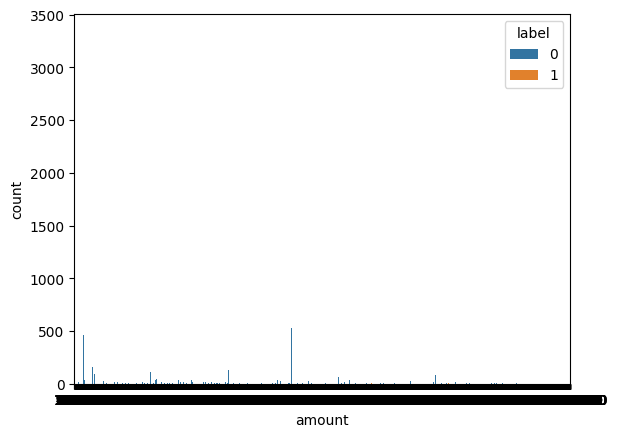

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('train_data.csv')
sns.countplot(x='amount', hue='label',data=data)
print(data.head(10))

### 1b. Describe the visualizations and provide relavant explanations of features and relations.

## 2. Imbalance task – 1 A4 – Individual

### 2a. Print ROC curves

### 2b. Analyse the performance of the classifiers. Explain which method performs best.

### 2c. Is using SMOTE a good idea? Why (not)?

## 3. Privacy task – 1 A4 – Individual

### 3a. Print ROC curves

### 3b. Analyse the performance of the classifiers. Explain which method performs best.

### 3c. Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

## 4. Classification task – 2 A4

### 4a. Print relevant plots and metrics with clear headings.

### 4b. Explain the applied data pre-processing steps, learning algorithms, and post-processing steps or ensemble methods. Compare the performance of the two algorithms, focusing on performance criteria that are relevant in practice, use 10-fold cross-validation.

## 5. Bonus task – 1 A4

### 5a. Provide code and report below